# Import Libraries

In [1]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
import optuna

/home/mmostafa/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the Datasets

In [2]:
train_df = pd.read_csv("../data/pre_train.csv", index_col=0)
val_df = pd.read_csv("../data/pre_val.csv", index_col=0)
test_df = pd.read_csv("../data/pre_test.csv", index_col=0)

In [3]:
train_df.isna().sum()

Pressure                     0
Temp                         0
Temp (dew point)             0
Relative Humidity            0
Saturation vapor pressure    0
Vapor pressure               0
Vapor pressure deficit       0
Specific humidity            0
Water vapor concentration    0
Airtight                     0
Wx                           0
Wy                           0
Day sin                      0
Day cos                      0
Year sin                     0
Year cos                     0
dtype: int64

In [4]:
val_df.isna().sum()

Pressure                     0
Temp                         0
Temp (dew point)             0
Relative Humidity            0
Saturation vapor pressure    0
Vapor pressure               0
Vapor pressure deficit       0
Specific humidity            0
Water vapor concentration    0
Airtight                     0
Wx                           0
Wy                           0
Day sin                      0
Day cos                      0
Year sin                     0
Year cos                     0
dtype: int64

## Data Windowing

The models will make a set of predictions based on a window of consecutive samples from the data.

So, we will create Dataset Class that will be responsible for splitting the data into windows.

We will make the dataset adapt to the type of model we want to train (multi-output or single-output) by changing the `label_columns` parameter.

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        label_column: str = "Temp",
        input_width: int = 1,
        output_width: int = 1,
        shift: int = 1,
    ):
        self.data_df = data
        self.data = data.to_numpy()
        self.input_width = input_width
        self.output_width = output_width
        self.shift = shift

        if label_column:
            self.label_column_idx = data.columns.get_loc(label_column)
        else:
            self.label_column_idx = slice(None)

    def __len__(self):
        return (
            self.data.shape[0] - (self.input_width + self.output_width + self.shift) + 1
        )

    def __getitem__(self, idx):
        start_idx = idx
        end_idx = idx + self.input_width
        inputs = self.data[start_idx:end_idx]

        start_idx = end_idx + self.shift
        end_idx = start_idx + self.output_width
        labels = self.data[start_idx:end_idx, self.label_column_idx]
        return torch.from_numpy(inputs).to(torch.float), torch.from_numpy(labels).to(
            torch.float
        )

Create a function to plot the input features, label, and prediction over a batch.

In [6]:
def plot_windows(
    dataset: TimeSeriesDataset,
    inputs_batch: torch.tensor,
    labels_batch: torch.tensor,
    model: nn.Module = None,
    plot_column: str = "Temp",
    num_samples: int = 1,
):
    """Plot the features, Labels and predictions for a single batch created by the dataloader"""
    _, axes = plt.subplots(
        nrows=num_samples,
        ncols=1,
        figsize=(14, 3 * num_samples),
        sharex=True,
        sharey=True,
    )
    plot_col_index = dataset.data_df.columns.get_loc(plot_column)

    for i, ax in enumerate(np.array(axes).reshape(-1)):
        inputs = inputs_batch[i, ...]
        labels = labels_batch[i, ...]
        if model:
            with torch.no_grad():
                preds = model(inputs.unsqueeze(0))

        # Plotting the features labels
        ax.plot(
            range(dataset.input_width),
            inputs[:, plot_col_index],
            label="Input Feature Labels",
            marker=".",
        )
        # Plotting the true labels
        ax.scatter(
            range(
                dataset.input_width + dataset.shift,
                dataset.input_width + dataset.shift + dataset.output_width,
            ),
            labels,
            label="True Labels",
            marker="o",
            c="green",
        )
        if model:
            # Plotting the predicted labels
            ax.scatter(
                range(
                    dataset.input_width + dataset.shift,
                    dataset.input_width + dataset.shift + dataset.output_width,
                ),
                preds.squeeze(0).numpy(),
                label="Predictions",
                marker="x",
                color="orange",
            )
    plt.legend(loc="upper left")
    plt.show()

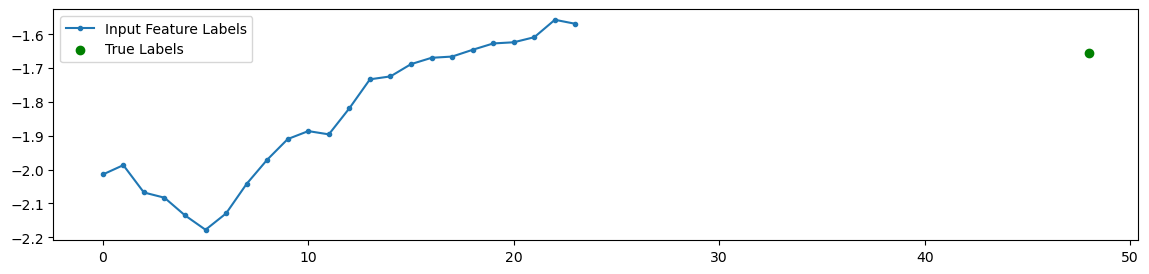

torch.Size([2, 24, 16]) torch.Size([2, 1])


In [7]:
# Try to plot the first batch of the training data
demo_dataset = TimeSeriesDataset(
    train_df, input_width=24, output_width=1, shift=24, label_column="Temp"
)
train_dataloader = DataLoader(demo_dataset, batch_size=2)

for inputs, labels in train_dataloader:
    plot_windows(demo_dataset, inputs, labels)
    print(inputs.shape, labels.shape)
    break

In [8]:
def train_model(
    model,
    train_loader: DataLoader,
    Criterion: torch.nn,
    Optimizer: torch.optim,
    num_epochs,
    lr=0.001,
):
    criterion = Criterion()
    optimizer = Optimizer(model.parameters(), lr=lr)

    model.train()
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch: {epoch}, Loss: {loss.item()}")

In [9]:
def evaluate_model(model, test_loader, Criterion: torch.nn):
    criterion = Criterion()
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    average_loss = total_loss / len(test_loader)
    return average_loss, inputs, labels

## Shortlist Promising Models

### Multi-Step Single Shot Models

We build a model that takes in the last 24 hours of data, and predicts the next 24 hours.

<p align="center">
    <img src="https://www.tensorflow.org/static/tutorials/structured_data/images/multistep_dense.png"/>
</p>


In [10]:
OUTPUT_SIZE = 24
INPUT_SIZE = 24
N_FEATURES = 16

In [11]:
train_dataset = TimeSeriesDataset(
    train_df,
    input_width=INPUT_SIZE,
    output_width=OUTPUT_SIZE,
    shift=1,
    label_column="Temp",
)
val_dataset = TimeSeriesDataset(
    val_df,
    input_width=INPUT_SIZE,
    output_width=OUTPUT_SIZE,
    shift=1,
    label_column="Temp",
)
test_dataset = TimeSeriesDataset(
    test_df,
    input_width=INPUT_SIZE,
    output_width=OUTPUT_SIZE,
    shift=1,
    label_column="Temp",
)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Baseline

We will use a simple Linear model as a baseline.

In [13]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        out = out[:, -1, :]
        return out


lr_model = LinearRegressionModel(N_FEATURES, OUTPUT_SIZE)

In [14]:
# Train the Linear Regression Model
train_model(lr_model, train_loader, nn.MSELoss, torch.optim.Adam, num_epochs=10)

Epoch: 0, Loss: 0.013087151572108269
Epoch: 1, Loss: 0.01470189169049263
Epoch: 2, Loss: 0.017052607610821724
Epoch: 3, Loss: 0.018708793446421623
Epoch: 4, Loss: 0.019854556769132614
Epoch: 5, Loss: 0.020638706162571907
Epoch: 6, Loss: 0.021159496158361435
Epoch: 7, Loss: 0.021497607231140137
Epoch: 8, Loss: 0.021715238690376282
Epoch: 9, Loss: 0.021855708211660385


In [15]:
lr_val_loss, inputs_sample, labels_sample = evaluate_model(
    lr_model, val_loader, nn.MSELoss
)

In [16]:
lr_val_loss

0.11101932557322448

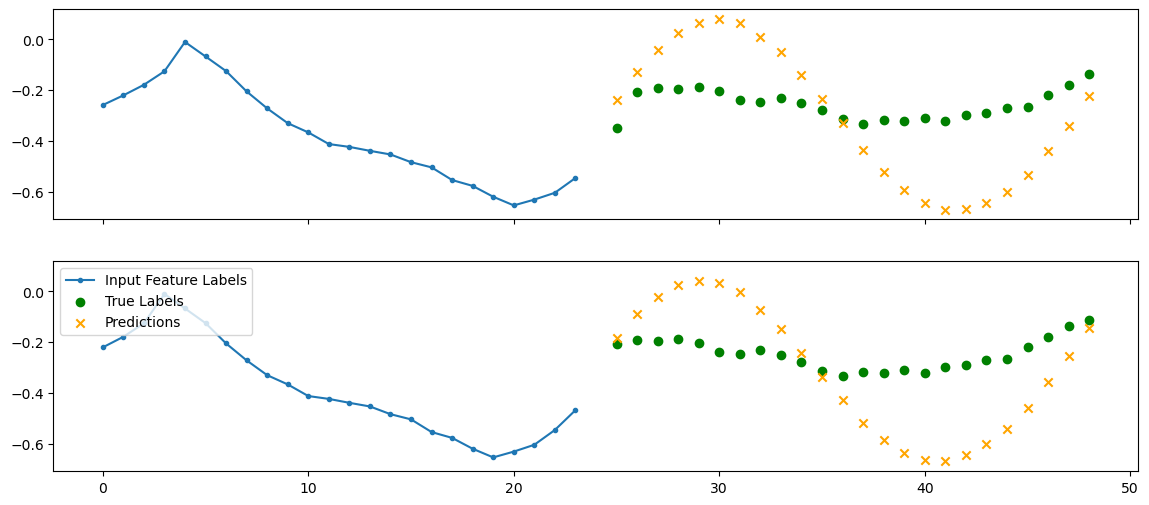

In [17]:
plot_windows(
    val_dataset,
    inputs_sample,
    labels_sample,
    model=lr_model,
    plot_column="Temp",
    num_samples=2,
)

#### GRU 

In [18]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out


# Initialize the GRU model
gru_model = GRUModel(
    input_size=N_FEATURES, hidden_size=128, num_layers=2, output_size=OUTPUT_SIZE
)

In [19]:
# Training the GRU model
train_model(gru_model, train_loader, nn.MSELoss, torch.optim.Adam, num_epochs=10)

Epoch: 0, Loss: 0.02456454373896122
Epoch: 1, Loss: 0.032419007271528244
Epoch: 2, Loss: 0.03458351641893387
Epoch: 3, Loss: 0.041227880865335464
Epoch: 4, Loss: 0.04631192609667778
Epoch: 5, Loss: 0.05260387435555458
Epoch: 6, Loss: 0.054536785930395126
Epoch: 7, Loss: 0.05283035710453987
Epoch: 8, Loss: 0.05667934566736221
Epoch: 9, Loss: 0.06252402067184448


In [20]:
# Evaluate the GRU model on the validation set
gru_val_loss, sample_input, sample_label = evaluate_model(
    gru_model, val_loader, nn.MSELoss
)

In [21]:
gru_val_loss

0.1007314844585092

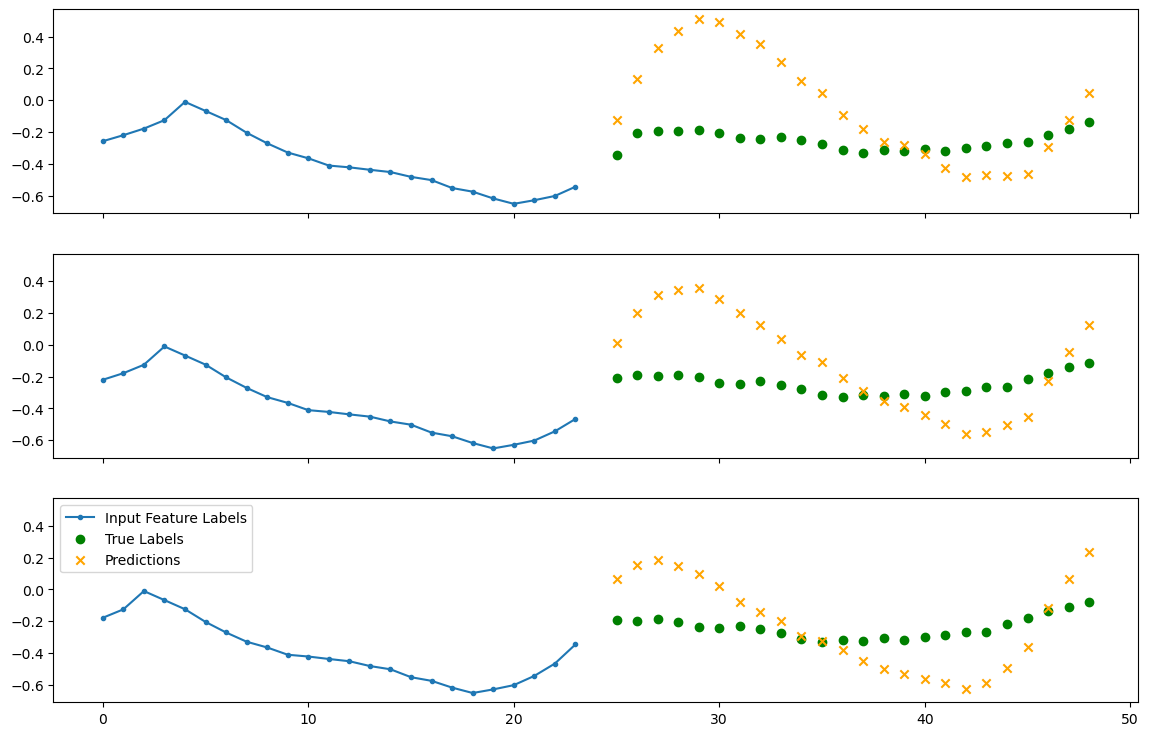

In [22]:
plot_windows(train_dataset, sample_input, sample_label, model=gru_model, num_samples=3)

#### LSTM

In [23]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        return out


# Create an instance of LSTM model
lstm_model = LSTMModel(
    input_dim=N_FEATURES, hidden_dim=128, layer_dim=2, output_dim=OUTPUT_SIZE
)

In [24]:
# Train the LSTM model
train_model(lstm_model, train_loader, nn.MSELoss, torch.optim.Adam, num_epochs=10)

Epoch: 0, Loss: 0.024501971900463104
Epoch: 1, Loss: 0.024599017575383186
Epoch: 2, Loss: 0.028608612716197968
Epoch: 3, Loss: 0.033186350017786026
Epoch: 4, Loss: 0.03572358563542366
Epoch: 5, Loss: 0.035000842064619064
Epoch: 6, Loss: 0.040692176669836044
Epoch: 7, Loss: 0.043217748403549194
Epoch: 8, Loss: 0.04634872078895569
Epoch: 9, Loss: 0.05446793511509895


In [25]:
# Evaluate the LSTM model on the validation set
lstm_val_loss, sample_input, sample_label = evaluate_model(
    lstm_model, val_loader, nn.MSELoss
)
lstm_val_loss

0.08888614556195623

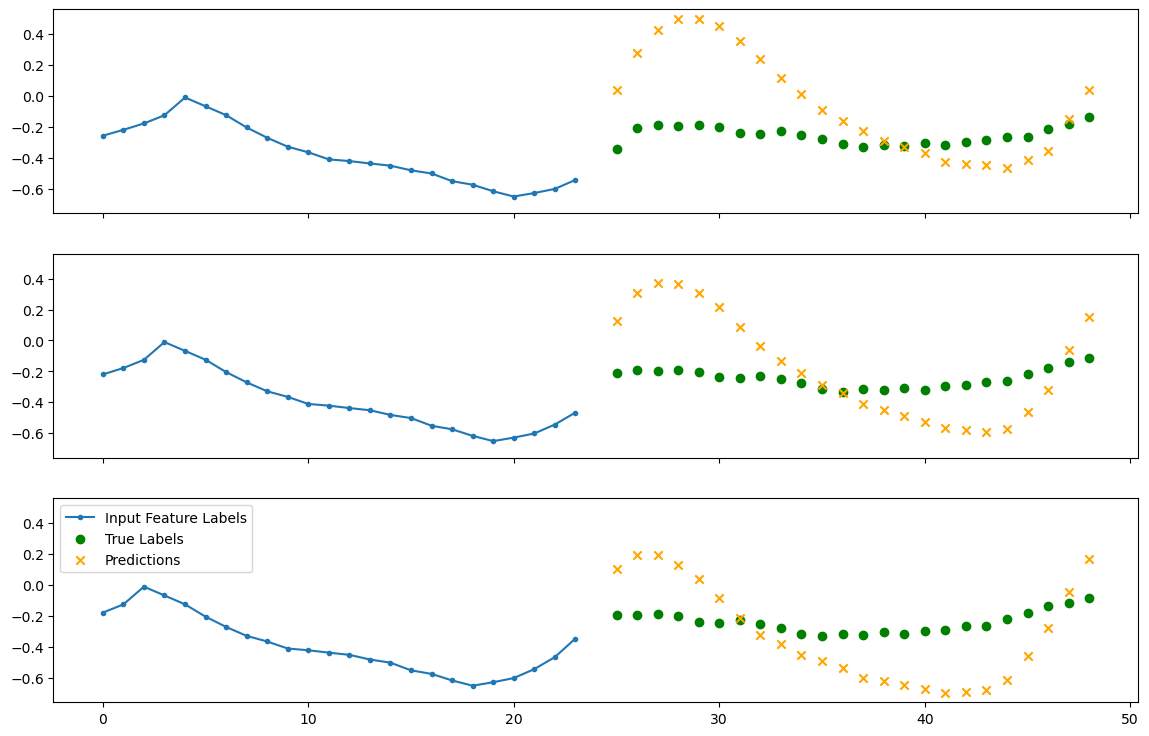

In [26]:
plot_windows(train_dataset, sample_input, sample_label, model=lstm_model, num_samples=3)

#### RNN 

In [27]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


# Create an instance of RNN model
rnn_model = RNNModel(input_dim=N_FEATURES, hidden_dim=128, output_dim=OUTPUT_SIZE)

In [28]:
# train the RNN model
train_model(rnn_model, train_loader, nn.MSELoss, torch.optim.Adam, num_epochs=10)

Epoch: 0, Loss: 0.016489963978528976


Epoch: 1, Loss: 0.014078387059271336
Epoch: 2, Loss: 0.019974105060100555
Epoch: 3, Loss: 0.027171548455953598
Epoch: 4, Loss: 0.03289408981800079
Epoch: 5, Loss: 0.023097727447748184
Epoch: 6, Loss: 0.033273886889219284
Epoch: 7, Loss: 0.020488357171416283
Epoch: 8, Loss: 0.04510600492358208
Epoch: 9, Loss: 0.03508056700229645


In [29]:
# Evaluate the RNN model on the validation set
rnn_val_loss, sample_input, sample_label = evaluate_model(
    rnn_model, val_loader, nn.MSELoss
)
rnn_val_loss

0.10195760329526554

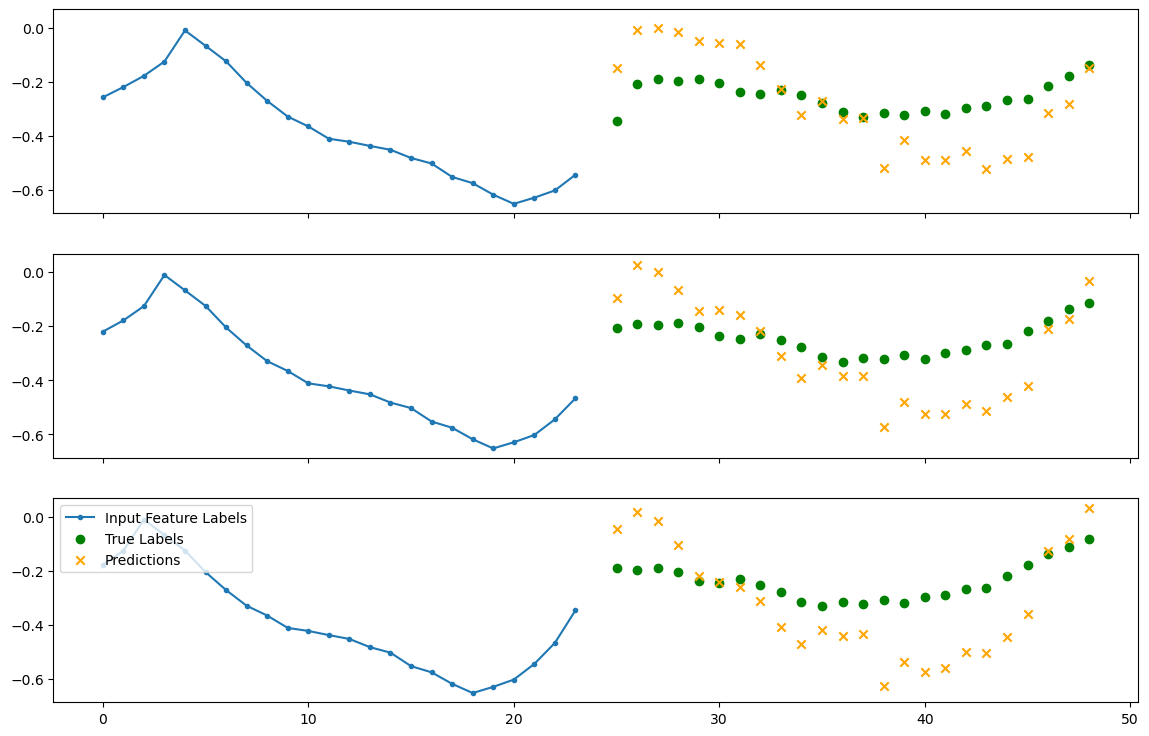

In [30]:
plot_windows(train_dataset, sample_input, sample_label, model=rnn_model, num_samples=3)

### Comparison

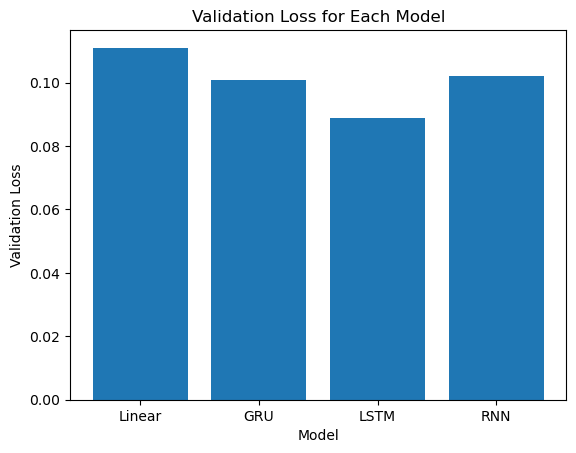

In [31]:
# Create a list of models
models = ["Linear", "GRU", "LSTM", "RNN"]

# Create a list of validation losses
val_losses = [lr_val_loss, gru_val_loss, lstm_val_loss, rnn_val_loss]

# Create the bar chart
plt.bar(models, val_losses)

# Add title and labels
plt.title("Validation Loss for Each Model")
plt.xlabel("Model")
plt.ylabel("Validation Loss")

# Show the plot
plt.show()

- The best model is the **LSTM** model. as it has the lowest MSE score on the validation set.

# LSTM Hyperparameter Tuning

In [32]:
def tunning(trial: optuna.Trial):
    lstm_model = LSTMModel(
        input_dim=N_FEATURES,
        hidden_dim=trial.suggest_int("hidden_dim", 32, 128, step=32),
        layer_dim=trial.suggest_int("layer_dim", 2, 4),
        output_dim=OUTPUT_SIZE,
    )

    # Decide the device to train on - cpu or gpu
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            lstm_model = nn.DataParallel(lstm_model)
    lstm_model.to(device)

    # Define the optimizer and the loss function
    optimizer = torch.optim.Adam(
        lstm_model.parameters(), lr=trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    )
    criterion = nn.MSELoss()

    # Create the train and validation dataloaders
    batch_size = trial.suggest_int("batch_size", 32, 128, step=32)
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
    )
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    # Training Loop
    for epoch in range(trial.suggest_int("epochs", 5, 20, step=5)):
        running_loss = 0.0
        lstm_model.train()
        for i, (inputs, labels) in enumerate(train_dataloader):
            # Get the data and labels, transfer them to the device
            inputs, labels = inputs.to(device), labels.to(device)

            # do the forward pass
            outputs = lstm_model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Clear the gradients, perform a backward pass, and update the weights
            optimizer.zero_grad()

            # Calculate the gradients
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save the loss
            running_loss += loss.item()

        # Evaluation Loop
        lstm_model.eval()
        val_loss = 0.0
        val_steps = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                # Load the data and labels to the device
                inputs, labels = inputs.to(device), labels.to(device)

                # Do the forward pass
                outputs = lstm_model(inputs)

                # Calculate the loss
                loss = criterion(outputs, labels)

                # Update the validation loss
                val_loss += loss.cpu().numpy()
                val_steps += 1

        trial.report(val_loss / val_steps, epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()

    return val_loss / val_steps

In [33]:
# Create an optuna study
study = optuna.create_study(direction="minimize")

# Start tunning
study.optimize(tunning)

# get the best trial
best_trial = study.best_trial

# Print the params of the best trial
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

[I 2023-11-23 18:39:57,334] A new study created in memory with name: no-name-0f5265b0-d055-42a2-9a25-0db21c9cc098


[I 2023-11-23 18:40:46,164] Trial 0 finished with value: 0.13152369653636758 and parameters: {'hidden_dim': 32, 'layer_dim': 3, 'lr': 0.00011371252742550053, 'batch_size': 96, 'epochs': 10}. Best is trial 0 with value: 0.13152369653636758.
[I 2023-11-23 18:43:01,185] Trial 1 finished with value: 0.8155465036994074 and parameters: {'hidden_dim': 128, 'layer_dim': 4, 'lr': 0.002684627495583344, 'batch_size': 128, 'epochs': 15}. Best is trial 0 with value: 0.13152369653636758.
[I 2023-11-23 18:44:18,769] Trial 2 finished with value: 2.2792252868413927 and parameters: {'hidden_dim': 96, 'layer_dim': 4, 'lr': 0.0681113554013752, 'batch_size': 96, 'epochs': 15}. Best is trial 0 with value: 0.13152369653636758.
[I 2023-11-23 18:44:55,695] Trial 3 finished with value: 1.1723245825255062 and parameters: {'hidden_dim': 128, 'layer_dim': 3, 'lr': 0.019819133685313003, 'batch_size': 64, 'epochs': 5}. Best is trial 0 with value: 0.13152369653636758.
[I 2023-11-23 18:45:23,139] Trial 4 finished with

# Testing 

In [ ]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=best_trial.params["batch_size"],
    shuffle=False,
)

In [ ]:
# Create a new LSTM model with the best trial params
lstm_model = LSTMModel(
    input_dim=N_FEATURES,
    hidden_dim=best_trial.params["hidden_dim"],
    layer_dim=best_trial.params["layer_dim"],
    output_dim=OUTPUT_SIZE,
)

In [ ]:
# Train the model on the entire training data
train_model(
    lstm_model,
    train_dataloader,
    nn.MSELoss,
    torch.optim.Adam,
    lr=best_trial.params["lr"],
    num_epochs=best_trial.params["epochs"],
)

/home/mmostafa/miniconda3/envs/aienv10/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Loss: 0.03791409358382225
Epoch: 1, Loss: 0.03844807669520378
Epoch: 2, Loss: 0.04021987318992615
Epoch: 3, Loss: 0.04525138810276985
Epoch: 4, Loss: 0.05437299236655235
Epoch: 5, Loss: 0.0541047565639019
Epoch: 6, Loss: 0.058445174247026443
Epoch: 7, Loss: 0.06775065511465073
Epoch: 8, Loss: 0.08375411480665207
Epoch: 9, Loss: 0.07126200944185257
Epoch: 10, Loss: 0.06893258541822433
Epoch: 11, Loss: 0.05993718281388283
Epoch: 12, Loss: 0.060778919607400894
Epoch: 13, Loss: 0.06674674153327942
Epoch: 14, Loss: 0.05900915339589119
Epoch: 15, Loss: 0.06307622045278549
Epoch: 16, Loss: 0.07131834328174591
Epoch: 17, Loss: 0.06463385373353958
Epoch: 18, Loss: 0.09775426238775253
Epoch: 19, Loss: 0.09007204324007034


In [ ]:
# Evaluate the model on the test set
test_loss, sample_input, sample_label = evaluate_model(
    lstm_model, test_dataloader, nn.MSELoss
)
test_loss

0.30050490841721045